In [2]:
import torch
import os
import random
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

torch.manual_seed(42)

import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import resnet152,ResNet152_Weights
from torchvision import transforms
import torchvision
from torchvision.datasets import ImageFolder
from torchinfo import summary

D:\Python Projects For Github\Chest-Cancer detector\cancer\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.__version__

'2.0.1+cu117'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
TRAIN_DIR = './Data/train'
VAL_DIR = './Data/valid'
TEST_DIR = './Data/test'

In [6]:
labels = os.listdir(TRAIN_DIR)

In [7]:
img_list = list()

for root, dirname, files in os.walk('./Data/train/'):
    for file in files:
        if file.endswith(".png"):
            img_list.append((os.path.join(root, file)))

In [8]:
# Transforms to prepare data for training
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(size=(224,224)),
    transforms.RandomAutocontrast(p=0.6),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    
])

In [9]:
train_data = ImageFolder(root=TRAIN_DIR,
                                  transform=data_transform)

test_data = ImageFolder(root=TEST_DIR,
                              transform=data_transform)
val_data = ImageFolder(root=VAL_DIR,
                              transform=data_transform)

In [10]:
print(f"Train data: {train_data}\n Test data: {test_data}\n Valid data: {val_data}")

Train data: Dataset ImageFolder
    Number of datapoints: 613
    Root location: ./Data/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomAutocontrast(p=0.6)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
 Test data: Dataset ImageFolder
    Number of datapoints: 315
    Root location: ./Data/test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomAutocontrast(p=0.6)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
 Valid data: Dataset ImageFolder
    Number of datapoints: 72
    Root location: ./Data/valid
    StandardTransform
Transform: Compose(

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Before and after transform')

<Figure size 3000x800 with 0 Axes>

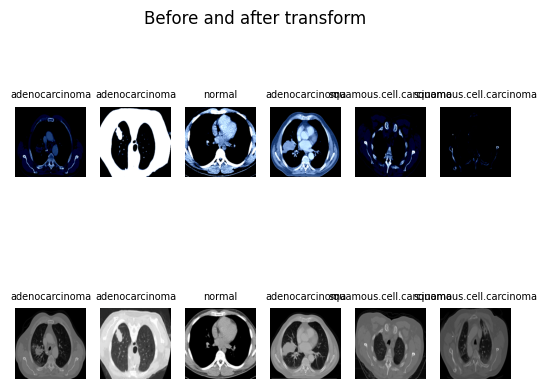

In [11]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


#choose random images from list
random_samples_idx = random.sample(range(len(train_data)), k=6)


plt.figure(figsize=(30, 8))
fig,ax = plt.subplots(2,6)


for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = train_data[targ_sample][0], train_data[targ_sample][1]
    
    # Convert CHW to HWC
    targ_image_adjust = targ_image.permute(1, 2, 0)

        
    ax[0,i].imshow(targ_image_adjust)
    ax[0,i].axis("off")
    title = f"{train_data.classes[targ_label]}"
    ax[0,i].set_title(title, fontsize = 7)
    
    trans_img = (targ_image_adjust.numpy() * std + mean).clip(0,1)
    ax[1,i].imshow(trans_img)
    ax[1,i].axis("off")
    ax[1,i].set_title(f"{title}",fontsize = 7)
    
fig.suptitle("Before and after transform")

In [12]:
train_loader = DataLoader(train_data,shuffle=True,batch_size=32)
test_loader = DataLoader(test_data,shuffle=False,batch_size=8)
valid_loader = DataLoader(val_data,shuffle=False,batch_size=1)

In [13]:
weights = ResNet152_Weights.IMAGENET1K_V2

In [14]:
resnet = resnet152(weights=weights)

In [15]:
# This is used to remove Training the full layers
for param in resnet.parameters():
    param.requires_grad = False

In [16]:
resnet.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 4), 
    nn.LogSoftmax(dim=1)
    )

In [17]:
# summary of the model
summary(resnet,input_size = [32, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 4]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [22]:
resnet.to(device)
# loss function
loss_fn = nn.CrossEntropyLoss()
# Optimizer for weight adjustment
optimizer = torch.optim.Adam(resnet.parameters(), lr = 0.001)

In [23]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward Tracking(autograd)
        loss.backward()

        # Optimizer step(making changes to the weigths)
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [24]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager this remove grad
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [25]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 20):
    
    #Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_loader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # Print Results after each epoch
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [31]:
# Set number of epochs
NUM_EPOCHS = 10

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model
model_results = train(model=resnet, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and duration of training
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|███▉                                   | 1/10 [00:11<01:44, 11.57s/it]

Epoch: 1 | train_loss: 0.0591 | train_acc: 0.9791 | test_loss: 0.8424 | test_acc: 0.7438


 20%|███████▊                               | 2/10 [00:22<01:30, 11.36s/it]

Epoch: 2 | train_loss: 0.0372 | train_acc: 0.9838 | test_loss: 0.8235 | test_acc: 0.7406


 30%|███████████▋                           | 3/10 [00:34<01:19, 11.32s/it]

Epoch: 3 | train_loss: 0.0697 | train_acc: 0.9869 | test_loss: 0.6784 | test_acc: 0.8094


 40%|███████████████▌                       | 4/10 [00:45<01:07, 11.30s/it]

Epoch: 4 | train_loss: 0.0537 | train_acc: 0.9728 | test_loss: 0.6922 | test_acc: 0.7479


 50%|███████████████████▌                   | 5/10 [00:56<00:56, 11.28s/it]

Epoch: 5 | train_loss: 0.0365 | train_acc: 0.9875 | test_loss: 1.0380 | test_acc: 0.6906


 60%|███████████████████████▍               | 6/10 [01:07<00:45, 11.28s/it]

Epoch: 6 | train_loss: 0.0399 | train_acc: 0.9822 | test_loss: 0.7544 | test_acc: 0.7531


 70%|███████████████████████████▎           | 7/10 [01:19<00:33, 11.27s/it]

Epoch: 7 | train_loss: 0.0266 | train_acc: 0.9906 | test_loss: 0.9181 | test_acc: 0.7125


 80%|███████████████████████████████▏       | 8/10 [01:30<00:22, 11.27s/it]

Epoch: 8 | train_loss: 0.0300 | train_acc: 0.9869 | test_loss: 0.7549 | test_acc: 0.7688


 90%|███████████████████████████████████    | 9/10 [01:41<00:11, 11.27s/it]

Epoch: 9 | train_loss: 0.0373 | train_acc: 0.9844 | test_loss: 1.1046 | test_acc: 0.7219


100%|██████████████████████████████████████| 10/10 [01:52<00:00, 11.29s/it]

Epoch: 10 | train_loss: 0.0263 | train_acc: 0.9969 | test_loss: 0.8240 | test_acc: 0.7688
Total training time: 112.868 seconds


In [32]:
def plot_loss_curves(result):
    
    # Getting variables from dict
    train_loss = result['train_loss']
    test_loss = result['test_loss']
    
    train_acc = result['train_acc']
    test_acc = result['test_acc']
    
    epoch = range(len(train_acc))
    
    plt.figure(figsize=(15,7))
    
    # Loss plot
    plt.subplot(1,2,1)
    plt.plot(epoch, train_loss, label='Train_loss')
    plt.plot(epoch, test_loss, label='Test_loss')
    plt.xlabel('Epoch')
    plt.title('Loss')
    
    # Accuarcy Plot
    plt.subplot(1,2,2)
    plt.plot(epoch, train_acc, label='Train_accuracy')
    plt.plot(epoch, test_acc, label='Test accuracy')
    plt.xlabel('Epoch')
    plt.title('Accuracy')

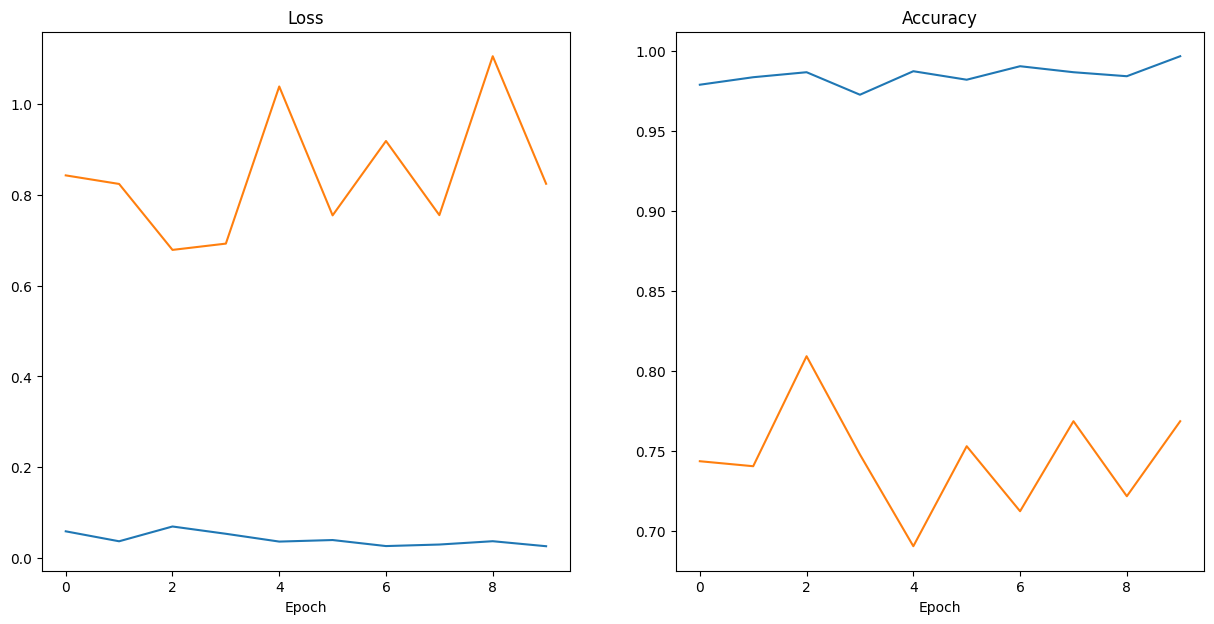

In [33]:
plot_loss_curves(model_results)

In [26]:
# used to Find accuracy of model
def accuracy_of_model(model,loader,loss_fn):
    # Put model in eval mode
    model.eval()
    val_loss = 0
    val_acc = 0
    
    with torch.inference_mode():
        for batch,(data,target) in enumerate(loader):
            data,target = data.to(device),target.to(device)

            # make prediction
            pred = model(data)
            
            # calculate loss
            loss = loss_fn(pred,target)
            val_loss = loss.item()
            
            # calculate accuracy
            pred_label = torch.argmax(torch.softmax(pred,dim=1),dim=1)
            val_acc += ((pred_label == target).sum().item()/len(pred_label))
    val_loss = val_loss / len(loader)
    val_acc = val_acc / len(loader)
    return val_acc,val_loss

In [27]:
accuracy,loss = accuracy_of_model(resnet,valid_loader,loss_fn)

In [28]:
print(f'Accuracy of Resnet model(validation): {accuracy*100}')
print(f'Loss of Resnt model(validation): {loss}')

Accuracy of Resnet model(validation): 83.33333333333334
Loss of Resnt model(validation): 2.0601298375469116e-05


In [29]:
classes = train_data.classes

In [30]:
torch.save(resnet.state_dict(),'./BestModel/Resnet_cancer.pth')

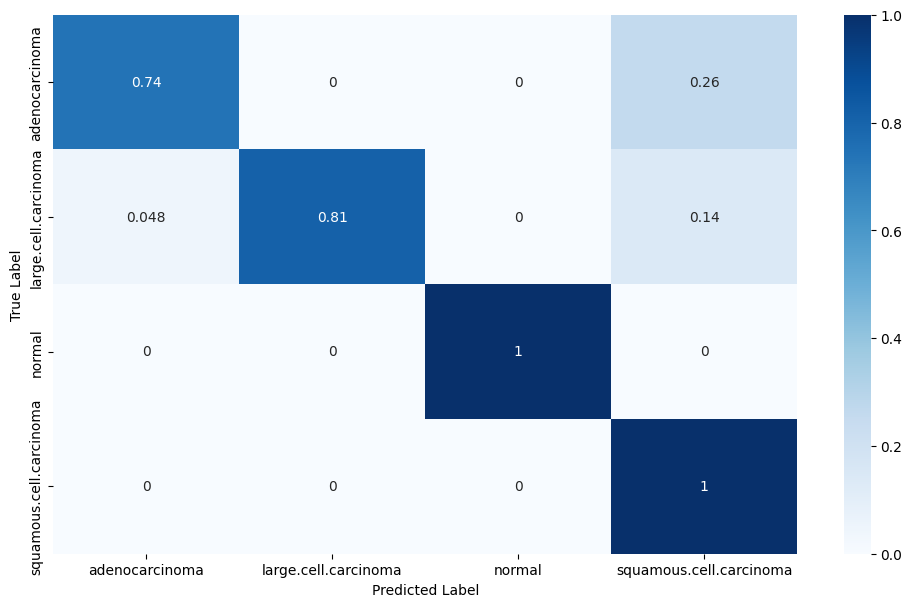

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

resnet.eval()
# iterate over test data
with torch.inference_mode():
    for batch,(inputs, labels) in enumerate(valid_loader):
        
        inputs, labels = inputs.to(device),labels.to(device)
        output = resnet(inputs) # Feed Network

        output = torch.argmax(output, dim=1).cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
s = sns.heatmap(df_cm, annot=True,cmap="Blues")
s.set(xlabel='Predicted Label', ylabel='True Label')
plt.savefig('cmatrixResnet152.png')

In [21]:
resnet.load_state_dict(torch.load('BestModel/Resnet_cancer.pth',map_location=torch.device(device)))

<All keys matched successfully>